In [1]:
from fastai.vision.all import *
import pandas as pd
%matplotlib inline
set_seed(3865)

In [2]:
train_path='../input/resized-2015-2019-diabetic-retinopathy-detection/resized_traintest15_train19'
df = pd.read_csv('../input/resized-2015-2019-diabetic-retinopathy-detection/labels/traintestLabels15_trainLabels19.csv')
# for interactive DEBUG: reduce amount of train images : train_df = train_df[:1024]

In [3]:
df

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
92359,ffa47f6a7bf4,2
92360,ffc04fed30e6,0
92361,ffcf7b45f213,2
92362,ffd97f8cd5aa,0


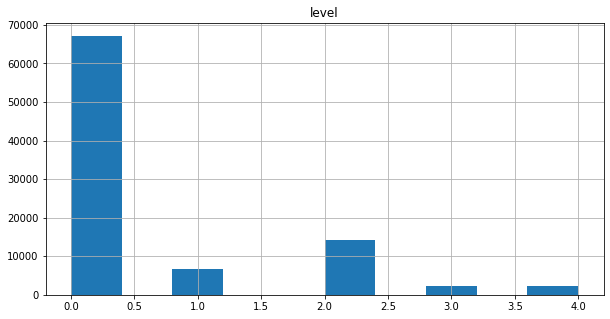

In [4]:
data = df[['level']].hist(figsize = (10, 5))

New Data Size: 50000 Old Size: 92364


array([[<AxesSubplot:title={'center':'level'}>]], dtype=object)

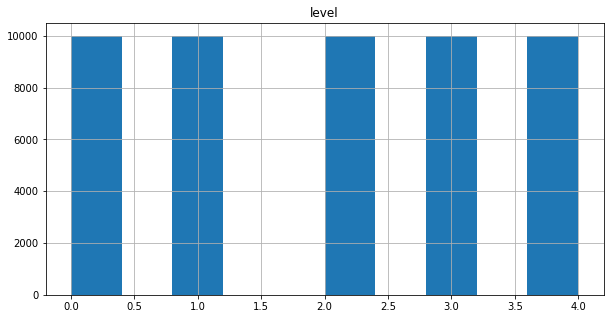

In [5]:
train_df = df.groupby(['level']).apply(lambda x: x.sample(10000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
train_df[['level']].hist(figsize = (10, 5))

In [6]:
import albumentations as Alb
class AlbTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
    
def get_augs(): return Alb.Compose([
    Alb.ShiftScaleRotate(rotate_limit=20, border_mode=0, value=(0,0,0) ),
    # Alb.Transpose(),
    Alb.HorizontalFlip(),
    # Alb.RandomRotate90(),
    Alb.RandomBrightnessContrast(),
    Alb.HueSaturationValue(
      hue_shift_limit=5, 
      sat_shift_limit=5, 
      val_shift_limit=5 ),
])

item_tfms = [Resize(224)] 
batch_tfms = [] 

In [7]:
dls = ImageDataLoaders.from_df(train_df, path=train_path, 
    fn_col='image', label_col='level', suff='.jpg', valid_pct=0.1, bs=32,
    item_tfms=item_tfms, batch_tfms=batch_tfms, shuffle=True)

train items: 45000 validation items: 5000


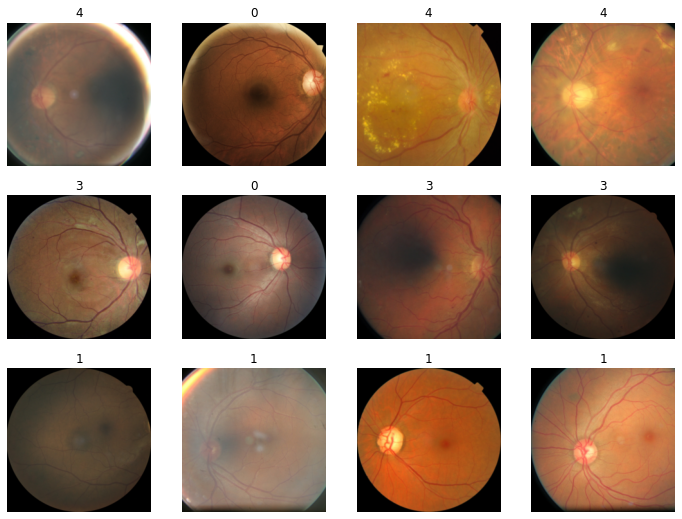

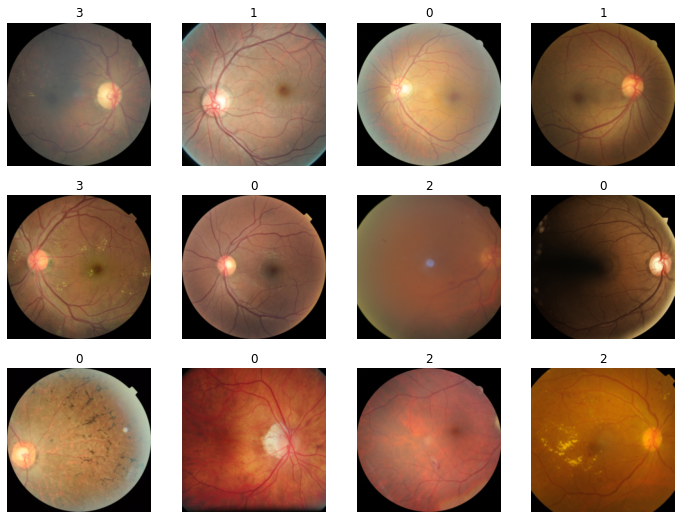

In [8]:
# uncomment to test data loaders
dls.train.show_batch(max_n=12)
print('train items:', len(dls.train.items), 'validation items:', len(dls.valid.items))
dls.valid.show_batch(max_n=12)

In [9]:
dls.vocab
dls.c

5

In [10]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

def precision_macro(inp, targ):
    pred = inp.argmax(dim=1)
    return precision_score(targ.cpu(), pred.cpu(), average='macro')

def recall_macro(inp, targ):
    pred = inp.argmax(dim=1)
    return recall_score(targ.cpu(), pred.cpu(), average='macro')

def f1_macro(inp, targ):
    pred = inp.argmax(dim=1)
    return f1_score(targ.cpu(), pred.cpu(), average='macro')

learn = vision_learner(
    dls, resnet34,
    path='.',
    loss_func=FocalLoss(),
    metrics=[accuracy]
)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

lrs.valley= 0.0006918309954926372


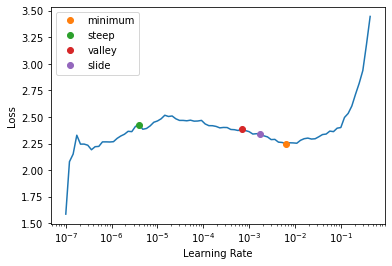

In [11]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print('lrs.valley=', lrs.valley)

epoch,train_loss,valid_loss,accuracy,time
0,0.776749,0.669784,0.475400,09:17


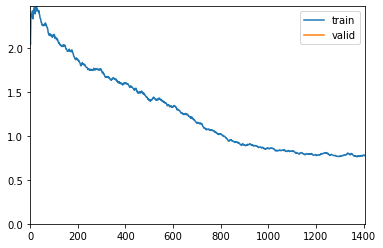

epoch,train_loss,valid_loss,accuracy,time
0,0.525684,0.462220,0.567800,09:00
1,0.380456,0.300044,0.699800,09:08
2,0.206407,0.236736,0.773800,09:07
3,0.100590,0.215998,0.808600,09:04


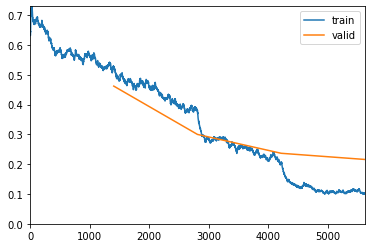

In [12]:
learn.fine_tune(4, cbs=[ShowGraphCallback()])

In [13]:
learn.save('retinopathy201519-rn34-1') 

Path('models/retinopathy201519-rn34-1.pth')

In [14]:
from sklearn.metrics import classification_report, f1_score

# Get predictions and targets
preds, targs = learn.get_preds()

# For multi-class classification
pred_labels = preds.argmax(dim=1)

# Compute F1
f1 = f1_score(targs, pred_labels, average='macro')
print(f"F1 Score: {f1:.4f}")

# Or full classification report
print(classification_report(targs, pred_labels))

F1 Score: 0.8089
              precision    recall  f1-score   support

           0       0.63      0.65      0.64      1013
           1       0.71      0.67      0.69      1032
           2       0.75      0.76      0.76       954
           3       0.98      0.98      0.98      1003
           4       0.97      0.99      0.98       998

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000



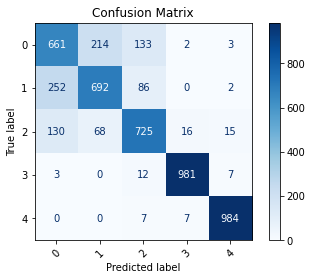

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Get the predictions and targets
preds, targs = learn.get_preds()

# Get predicted class indices
pred_labels = preds.argmax(dim=1)

# Compute confusion matrix
cm = confusion_matrix(targs, pred_labels)

# Display with labels
class_names = learn.dls.vocab if hasattr(learn.dls, 'vocab') else [str(i) for i in range(preds.shape[1])]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()